# MHKit Short-term Extreme Loads

Short-term extreme loads are typically required as part of a long-term extreme load estimate. 
A short-term extreme distribution is a probability distribution for the extreme value of a short-term (e.g. 3-hours) time-series. 

MHKiT includes functions adapted from the [WDRT](https://github.com/WEC-Sim/WDRT) for estimating the short-term extreme distribution. 
Several methods are included, which can be divided into two main  approaches:

1. Block maxima: approximate the short-term extreme distribution directly by fitting a probability distribution to the maxima from N distinct short-term blocks. 
2. Peaks distribution: approximate the short-term extreme distribution from the distribution of peaks from a time-series of arbitrary length. 

The two sets of methods will be demonstrated. 

**NOTE**: This notebook will walk through the two different approaches, and each method in them. The short-term extreme will be obtained step-by-step showing the intermediate outputs. However for most applications the `loads.extreme.short_term_extreme` function will be used directly in a single step. For this usage jump to the last section. 


The quantity (load) of interest can be anythig related to the WEC, such as position (e.g. PTO extension, heave displacement), velocity, structural load, mooring loads, etc. 
For this example we will use the wave elevation as the quantity of interest, since such time-series can be easily created without having to run a WEC-modeling software. 
The short-term period of interest will be 3-hours.

An important pre-processing step is making the time-series zero-mean. 
In this case, since wave elevation is zero-mean no pre-processing is needed.



We  will start by importing the `loads.extreme` module which includes these different methods, and  the `wave.resource` module to create the response time-series. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mhkit.loads import extreme 
from mhkit.wave.resource import jonswap_spectrum, surface_elevation

We now define the short-term period  and  the wave spectrum  we  will use  to generate synthetic time-series. 

In [2]:
# short-term period in seconds
t_st = 3.0 * 60.0 * 60.0 

# JONSWAP spectrum for creating short-term time-series
T_min = 1  # s
Tp = 8  # s
Hs = 1.5  # m
f0 = 1/t_st
f_max = 1/T_min
Nf = int(f_max/f0)
f = np.linspace(f0, f_max, Nf)
S = jonswap_spectrum(f, Tp, Hs)

# time in seconds
time = np.linspace(0, t_st, 2*Nf+1)

## Block Maxima 

The short-term extreme distribution can be estimated directly from N time-series of short-term period. 
These time-series can be obtained, for instance, from N distinct simulations of the quantity of interest, or alternatively by dividing a long time-series of the quantity of interest  into blocks of length equal to the short-term period. 

In this example we will use N=10 for speed considerations, but this would be inadequately small for most real applications. 

We start by creating 10 3-hour time-series of  the  quantity of interest. 

In [3]:
N = 10
qoi_timeseries = [surface_elevation(S, time).values.squeeze() for _ in range(N)]

### 1. Find the maximum of each block.

In [4]:
block_maxima = [np.max(its) for its in qoi_timeseries]
block_maxima = np.array(block_maxima)

We can view the different time-series (change value of i). 

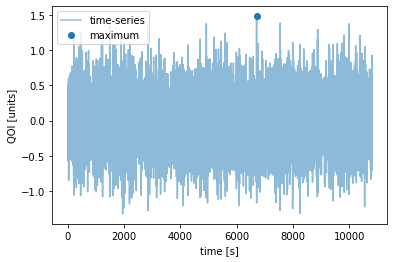

In [5]:
i = 0  # select: 0-9

plt.figure()
line, = plt.plot(time, qoi_timeseries[i], alpha=0.5, label='time-series')
plt.plot(time[np.argmax(qoi_timeseries[i])], block_maxima[i],
            'o', color=line.get_color(), label='maximum')
plt.xlabel('time [s]')
plt.ylabel('QOI [units]')
plt.legend()
plt.show()

Alternatively we could have created a single time-series of length N times the short-term period (30 hours) and used the `extreme.block_maxima` function to split it into blocks and  return the block maxima. 

### 2. Fit a distribution to the block maxima
We can now get the short-term extreme distribution by fitting either a generalized extreme value distribution or a Gumbel (right) distributions to these N=10 maxima. 
We will compare both methods. 

In [6]:
# generalized extreme value distribution
ste_gev = extreme.ste_block_maxima_GEV(block_maxima)
# Gumbel (right) distribution
ste_gum = extreme.ste_block_maxima_Gumbel(block_maxima)

The outputs of these functions are probability distributions (`scipy.stats.rv_continuous`). 
These objects provide common statitistical functions (PDF, CDF, PPF, etc.) and metrics (expected value, median, etc).

GEV:
  Expected value: 1.4456743447871923
  95% interval: (1.2864729515997486, 1.6760899432751997)
Gumbel:
  Expected value: 1.4469149323734147
  95% interval: (1.2913743840968916, 1.7029655242805957)


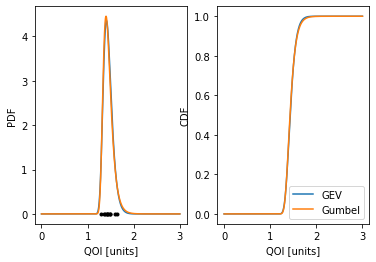

In [7]:
print(f'GEV:\n  Expected value: {ste_gev.expect()}\n  95% interval: ({ste_gev.ppf(0.025)}, {ste_gev.ppf(0.975)})')
print(f'Gumbel:\n  Expected value: {ste_gum.expect()}\n  95% interval: ({ste_gum.ppf(0.025)}, {ste_gum.ppf(0.975)})')

x = np.linspace(0, 3, 1000)

fig, axs = plt.subplots(1,2)
axs[0].plot(x, ste_gev.pdf(x))
axs[0].plot(x, ste_gum.pdf(x))
axs[0].plot(block_maxima, np.zeros(N), 'k.')
axs[1].plot(x, ste_gev.cdf(x), label='GEV')
axs[1].plot(x, ste_gum.cdf(x), label='Gumbel')
axs[0].set_ylabel('PDF')
axs[1].set_ylabel('CDF')
axs[1].legend()
axs[0].set_xlabel('QOI [units]')
axs[1].set_xlabel('QOI [units]');

## Peaks Distribution
The block maxima approach is the most direct way to approximate the short-term extreme but it requires a lot of data (N timeseries of length equal to the short-term period). 
An alternative approach approximates the short-term extreme from a timeseries of arbitrary length, even shorter than the short-term period, by fitting a distribution to the peaks of the timeseries. 

To demonstrate these methods we will approximate the 3-hour short-term extreme distribution from a single 1-hour timeseries. 

We start by generating this 1-hour response timeseries.

In [8]:
t_end = 1.0 * 60.0 * 60.0
timeseries_1hr = qoi_timeseries[0][time<t_end]
time_1hr = time[time < t_end]

(0.0, 3600.0)

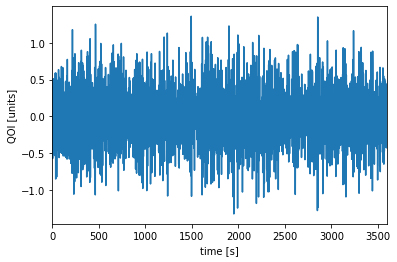

In [9]:
plt.figure()
plt.plot(time_1hr, timeseries_1hr)
plt.xlabel('time [s]')
plt.ylabel('QOI [units]')
plt.xlim([0, t_end])

### 1. Find the global peaks
The global peaks are the maximum between succesive zero-upcrossings. 
We use the `extreme.global_peaks` function  to find these peaks

In [10]:
t_peaks, qoi_peaks = extreme.global_peaks(time_1hr, timeseries_1hr)
npeaks = len(qoi_peaks)

(0.0, 60.0)

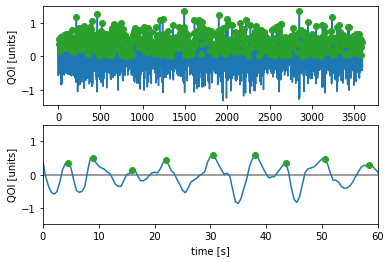

In [11]:
fig, axs = plt.subplots(2, 1)

axs[0].plot([0, t_end], [0, 0], color='tab:grey')
axs[0].plot(time_1hr, timeseries_1hr, color='tab:blue')
axs[0].plot(t_peaks, qoi_peaks, 'o', color='tab:green')
axs[0].set_xlabel('time [s]')
axs[0].set_ylabel('QOI [units]')

axs[1].plot([0, t_end], [0, 0], color='tab:grey')
axs[1].plot(time_1hr, timeseries_1hr, color='tab:blue')
axs[1].plot(t_peaks, qoi_peaks, 'o', color='tab:green')
axs[1].set_xlabel('time [s]')
axs[1].set_ylabel('QOI [units]')
axs[1].set_xlim([0, 60])

### 2. Fit a distribution to the peaks

MHKiT has three methods for doing this. 

1. Fit a Weibull distribution to all the peaks. 
2. Weibull tail fit: seven different weibull distributions are fit to successively smaller subsets of the highest peaks, and the peak distribution is taken as the average of these seven. 
3. Peaks over threshold:  generalized Pareto distribution is fit to all peaks above a certain threshold, typically taken as 1.4 standard deviations above the mean. 

We will now compare the results from these three methods.

In [12]:
# Weibull
peaks_w = extreme.peaks_distribution_Weibull(qoi_peaks)

# Weibull tail fit
peaks_wtf = extreme.peaks_distribution_WeibullTailFit(qoi_peaks)

# peaks over threshold
thresh = np.mean(qoi_peaks) + 1.4 * np.std(qoi_peaks)
peaks_pot = extreme.peaks_distribution_peaksOverThreshold(qoi_peaks, thresh)

The outputs are again `stats.rv_continuous` distributions. 
Note however that for the peaks over threshold method the distribution is only defined for values over the threshold, and many of the functionalities that require the entire distribution (e.g. expected value) are therefor not available.

Weibull:
  Expected value: 0.4414856461312863
  95% interval: (0.05569764675174127, 1.0736214918440266)
Weibull tail fit:
  Expected value: 0.45813865405942406
  95% interval: (0.07279468922621389, 1.034533546626356)


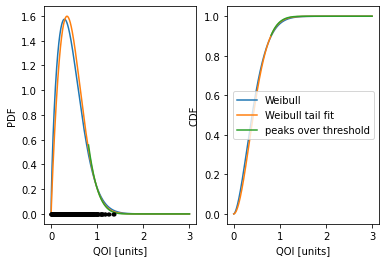

In [13]:
print(f'Weibull:\n  Expected value: {peaks_w.expect()}\n  95% interval: ({peaks_w.ppf(0.025)}, {peaks_w.ppf(0.975)})')
print(f'Weibull tail fit:\n  Expected value: {peaks_wtf.expect()}\n  95% interval: ({peaks_wtf.ppf(0.025)}, {peaks_wtf.ppf(0.975)})')

fig, axs = plt.subplots(1,2)
axs[0].plot(x, peaks_w.pdf(x))
axs[0].plot(x, peaks_wtf.pdf(x))
axs[0].plot(x, peaks_pot.pdf(x))
axs[0].plot(qoi_peaks, np.zeros(npeaks), 'k.')
axs[1].plot(x, peaks_w.cdf(x), label='Weibull')
axs[1].plot(x, peaks_wtf.cdf(x), label='Weibull tail fit')
axs[1].plot(x, peaks_pot.cdf(x), label='peaks over threshold')
axs[0].set_ylabel('PDF')
axs[1].set_ylabel('CDF')
axs[1].legend()
axs[0].set_xlabel('QOI [units]')
axs[1].set_xlabel('QOI [units]');

### 3. Obtain the short-term extreme distribution from the peaks distribution

We do this using the peaks distribution and an approximation for the number of peaks per short-term period. 
We use the `extreme.ste_peaks` function for this.   

In [14]:
N_st = extreme.npeaks_st(npeaks, t_end, t_st) 
print(f"Approximate number of peaks in a (3-hours) short-term period: {N_st}")

ste_w = extreme.ste_peaks(peaks_w, N_st)
ste_wtf = extreme.ste_peaks(peaks_wtf, N_st)
ste_pot = extreme.ste_peaks(peaks_pot, N_st)

Approximate number of peaks in a (3-hours) short-term period: 1851.0


Again the outputs are `stats.rv_continuous` distributions. 

Weibull:
  Expected value: 1.7081739592804117
  95% interval: (1.464142401222819, 2.07647236637966)


/Users/cmichel/opt/anaconda3/envs/mhkit/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2772: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  vals = integrate.quad(fun, lb, ub, **kwds)[0] / invfac


Weibull tail fit:
  Expected value: 1.5685013326507828
  95% interval: (1.366463163680433, 1.8694322065871696)
Peaks over threshold:
  Expected value: 1.4381978997984366
  95% interval: (1.3018395314712075, 1.604632210593728)


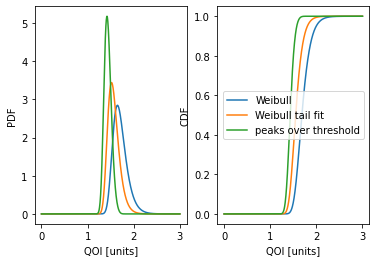

In [15]:
print(f'Weibull:\n  Expected value: {ste_w.expect()}\n  95% interval: ({ste_w.ppf(0.025)}, {ste_w.ppf(0.975)})')
print(f'Weibull tail fit:\n  Expected value: {ste_wtf.expect()}\n  95% interval: ({ste_wtf.ppf(0.025)}, {ste_wtf.ppf(0.975)})')
print(f'Peaks over threshold:\n  Expected value: {ste_pot.expect()}\n  95% interval: ({ste_pot.ppf(0.025)}, {ste_pot.ppf(0.975)})')

fig, axs = plt.subplots(1,2)
axs[0].plot(x, ste_w.pdf(x))
axs[0].plot(x, ste_wtf.pdf(x))
axs[0].plot(x, ste_pot.pdf(x))
axs[1].plot(x, ste_w.cdf(x), label='Weibull')
axs[1].plot(x, ste_wtf.cdf(x), label='Weibull tail fit')
axs[1].plot(x, ste_pot.cdf(x), label='peaks over threshold')
axs[0].set_ylabel('PDF')
axs[1].set_ylabel('CDF')
axs[1].legend()
axs[0].set_xlabel('QOI [units]')
axs[1].set_xlabel('QOI [units]');

## The `loads.extreme.short_term_extreme` function

This example showed step-by-step how to estimate the short-term extreme using different methods. 
However for most use cases the results from the intermediate steps are not of interest. 
The estimated short-term extreme distribution can be obtained directly from a timeseries of the response using the `loads.extreme.short_term_extreme` function. 
For the methods based on fitting the peaks the timeseries can be of arbitrary length, while for methods based on block maxima it should be many times longer than the short-term period. 

As an example the Weibull tail fit approximation of the short-term extreme distribution can be obtianed in a single step. 
The function takes the time series (time, response), the desired short-term period, and the method as inputs.

In [16]:
ste_wtf = extreme.short_term_extreme(time_1hr, timeseries_1hr, t_st, method='peaksWeibull')